In [ ]:
import pandas as pd
import numpy as np
import os

os.chdir("/content/drive/MyDrive/ML 대회/HDD")
df = pd.read_csv("./preprocessed/df_ver4-no-le.csv")
df.head()

,cr_ID_counts,eq_ID_counts,ramp_scale,servo_scale,data_scale,assem_hour,assem_min,pro_day,pro_hour,pro_min,pro_sec,pro_assem,ramp_cr_mean,servo_cr_mean,data_cr_mean,ramp_eq_mean,servo_eq_mean,data_eq_mean,cr_proassem,eq_proassem,defect_all,defect_minus,ramp_proassem,ramp_pro_sum,ramp_pro_mean,cr_ID,eq_ID,status
0,1602,2103,1.590083,1.284244,-0.632440,9,36,9,11,33,55,7075.0,2466.691011,4178.242821,3012.568664,2415.000951,4205.032335,3011.637660,5818.566167,5973.025202,7424.0,4742.0,0.644664,11254793.0,2479.029295,CRSTR01L,EGRWT0113,pass
1,1600,2148,1.224793,-1.457878,2.688988,2,13,10,3,16,18,3798.0,2448.328125,4206.899375,3051.370000,2502.050745,4204.669926,3020.332868,5846.791875,6082.363128,9856.0,6218.0,1.026330,11484543.0,2478.321752,CRSTR01Q,EGRWT0102,pass
2,1632,2144,0.738843,0.585852,-0.512401,23,6,7,0,0,12,3252.0,2453.363971,4109.984069,2993.390931,2453.709888,4214.579291,3025.781716,5700.965686,5935.769123,6580.0,3414.0,0.927429,11192258.0,2449.607792,CRSTR01N,EGRWT0103,pass
3,1602,2139,-0.038567,0.211576,0.361607,5,10,8,6,36,18,5178.0,2445.822097,4180.051186,2956.224719,2493.205704,4203.809724,2987.555400,5829.666667,5984.484806,7760.0,1070.0,0.309965,11506082.0,2539.413375,CRSTR01A,EGRWT0107,pass
4,1588,2103,-0.370799,-1.088103,0.337302,6,44,9,9,13,40,8980.0,2462.474811,4150.562972,2975.128463,2415.000951,4205.032335,3011.637660,5864.806675,5973.025202,5690.0,902.0,0.111581,11254793.0,2479.029295,CRSTR01C,EGRWT0113,pass


In [ ]:
# 범주형 변수
categorical_feature_names = ['cr_ID', 'eq_ID' ]

for var in categorical_feature_names:
    df[var] = df[var].astype("category")  #카테고리화

## 2. Modeling

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred, labels = ['pass','fail'])
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test, pred, pos_label='pass')
    recall = recall_score(y_test,pred, pos_label='pass')
    f1 = f1_score(y_test, pred, pos_label='pass')
    print('Confusion Matrix')
    print(confusion)
    print('Auccuracy : {0:.4f}, Precision : {1:.4f} , Recall : {2:.4f} , F1_Score : {3:.4f}'.format(accuracy , precision, recall, f1))

In [ ]:
df.columns.values

array(['cr_ID_counts', 'eq_ID_counts', 'ramp_scale', 'servo_scale',
       'data_scale', 'assem_hour', 'assem_min', 'pro_day', 'pro_hour',
       'pro_min', 'pro_sec', 'pro_assem', 'ramp_cr_mean', 'servo_cr_mean',
       'data_cr_mean', 'ramp_eq_mean', 'servo_eq_mean', 'data_eq_mean',
       'cr_proassem', 'eq_proassem', 'defect_all', 'defect_minus',
       'ramp_proassem', 'ramp_pro_sum', 'ramp_pro_mean', 'cr_ID', 'eq_ID',
       'status'], dtype=object)

### 1) RandomForest

In [ ]:
features = np.delete(df.columns.values,[len(df.columns.values)-1,len(df.columns.values)-2,len(df.columns.values)-3])
features

array(['cr_ID_counts', 'eq_ID_counts', 'ramp_scale', 'servo_scale',
       'data_scale', 'assem_hour', 'assem_min', 'pro_day', 'pro_hour',
       'pro_min', 'pro_sec', 'pro_assem', 'ramp_cr_mean', 'servo_cr_mean',
       'data_cr_mean', 'ramp_eq_mean', 'servo_eq_mean', 'data_eq_mean',
       'cr_proassem', 'eq_proassem', 'defect_all', 'defect_minus',
       'ramp_proassem', 'ramp_pro_sum', 'ramp_pro_mean'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features], df.status, test_size=0.25, stratify=df.status, random_state=123456)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)
# rf.fit(df[features],df.status)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

#### (1) Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(rf, X_train, y_train, cv=kfold)
print("K-fold Score:", scores_fold.mean())

K-fold Score: 0.9127916666666668


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = rf.predict(X_test)
cf = confusion_matrix(y_test, y_pred)
p = precision_score(y_test, y_pred, pos_label='pass')
r = recall_score(y_test, y_pred, pos_label='pass')
f1 = f1_score(y_test, y_pred, pos_label='pass')
acc = accuracy_score(y_test, y_pred)

print(cf)
print("Precision:", p)
print("Recall:", r)
print("F1:", f1)
print("Accuracy:", acc)

[[2375  105]
 [ 598 4922]]
Precision: 0.9791127909289835
Recall: 0.8916666666666667
F1: 0.933345975158813
Accuracy: 0.912125


In [ ]:
y_test.value_counts()

pass    5520
fail    2480
Name: status, dtype: int64

In [ ]:
feat_importances = pd.DataFrame(rf.feature_importances_, index=features, columns=["Importance"])
feat_importances.sort_values(by=['Importance'], axis=0, ascending=False)

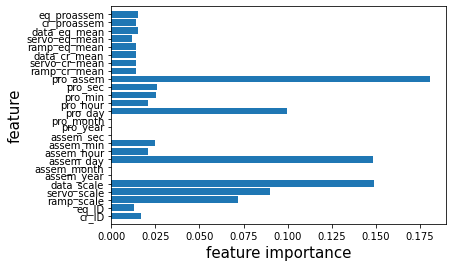

In [ ]:
import matplotlib.pyplot as plt
index = np.arange(df[features].shape[1])
plt.barh(index, rf.feature_importances_, align='center')
plt.yticks(index, X_train[features])
plt.ylim(-1, df[features].shape[1])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()   #### 불필요한 feature 판단

!!!!모델 저장!!!!!

In [ ]:
import pickle
filename = 'rf_all.sav'
pickle.dump(rf, open(filename, 'wb'))

### 2) lgbm

In [ ]:
from lightgbm import LGBMClassifier
## best parameters found.
lgb = LGBMClassifier(
    objective='binary',
    boosting='gbdt',
    learning_rate = 0.05,
    max_depth = 8,
    num_leaves = 80,
    n_estimators = 400,
    bagging_fraction = 0.8,
    feature_fraction = 0.9)
    #reg_alpha = 0.2,
    #reg_lambda = 0.4)
lgb.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.8, boosting='gbdt', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.05, max_depth=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=80, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
## Cross Validation
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(lgb, X_train, y_train, cv=kfold)
print("K-fold Score:", scores_fold.mean())

K-fold Score: 0.9099999999999999


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = lgb.predict(X_test)
cf = confusion_matrix(y_test, y_pred)
p = precision_score(y_test, y_pred, pos_label='pass')
r = recall_score(y_test, y_pred, pos_label='pass')
f1 = f1_score(y_test, y_pred, pos_label='pass')
acc = accuracy_score(y_test, y_pred)

print(cf)
print("Precision:", p)
print("Recall:", r)
print("F1:", f1)
print("Accuracy:", acc)

[[2367  113]
 [ 597 4923]]
Precision: 0.977561556791104
Recall: 0.8918478260869566
F1: 0.9327396741189845
Accuracy: 0.91125


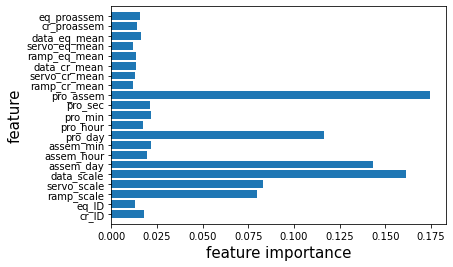

In [ ]:
import matplotlib.pyplot as plt
index = np.arange(df[features].shape[1])
plt.barh(index, rf.feature_importances_, align='center')
plt.yticks(index, X_train[features])
plt.ylim(-1, df[features].shape[1])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()   #### 불필요한 feature 판단

### Sampling

(1) 5:5

In [ ]:
df.shape[0]*0.7

22400.0

In [ ]:
train = df.loc[:df.shape[0]*0.7]
test = df.loc[df.shape[0]*0.7+1:,]

In [ ]:
train.status.value_counts()

pass    15409
fail     6992
Name: status, dtype: int64

In [ ]:
count_1, count_0 = train.status.value_counts()

train_1 = train[train.status == "pass"]
train_0 = train[train.status == "fail"]

print(count_1, count_0)

15409 6992


In [ ]:
train_0_over = train_0.sample(count_1, replace= True)
train_0_over.shape

(15409, 28)

In [ ]:
train_over = pd.concat([train_1, train_0_over], axis=0)
train_over.status.value_counts()

pass    15409
fail    15409
Name: status, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(train_over[features], train_over.status)
# rf.fit(df[features],df.status)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

In [ ]:
## Cross Validation  ##df_ver4-no-le
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(rf, train_over[features], train_over.status, cv=kfold)
print("K-fold Score:", scores_fold.mean())

y_pred = rf.predict(test[features])
get_clf_eval(test.status,y_pred)

K-fold Score: 0.9437991402292658
Confusion Matrix
[[5912  760]
 [  99 2828]]
Auccuracy : 0.9105, Precision : 0.9835 , Recall : 0.8861 , F1_Score : 0.9323


In [ ]:
test.status.value_counts()

pass    6672
fail    2927
Name: status, dtype: int64

In [ ]:
from sklearn.feature_selection import SelectFromModel
RFselector = SelectFromModel(estimator=RandomForestClassifier()).fit(df[features], df.status)
columns = df[features].columns
RFselected = columns[RFselector.get_support()]
len(RFselected)

9

In [ ]:
from sklearn.ensemble import RandomForestClassifier
count_1, count_0 = df.status.value_counts()

df_1 = df[df.status == "pass"]
df_0 = df[df.status == "fail"]
df_0_over = df_0.sample(count_1, replace= True)
df_over = pd.concat([df_1, df_0_over], axis=0)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(df_over[features], df_over.status)

import pickle
filename = './model/rf_dfver4-no-le.sav'
pickle.dump(rf, open(filename, 'wb'))

In [ ]:
df_over.status.value_counts()

pass    22081
fail    22081
Name: status, dtype: int64

###(3) Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0,max_iter=10000).fit(train_over[features], train_over.status)

In [ ]:
## Cross Validation  ##Oversampling
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(lr, df[features_lr], df.status, cv=kfold)
print("K-fold Score:", scores_fold.mean())

K-fold Score: 0.7595


###(4) KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_over[features], train_over.status)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
## Cross Validation  ##Oversampling
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(knn, df[features], df.status, cv=kfold)
print("K-fold Score:", scores_fold.mean())

K-fold Score: 0.6958125


###(5) Neural Net

In [ ]:
import pandas as pd
import numpy as np
import os

os.chdir("/content/drive/MyDrive/ML 대회/HDD")
df = pd.read_csv("./train.csv",parse_dates=["assembly_time","process_time"])
# 조립 시작 시간
df["assem_year"] = df["assembly_time"].dt.year
df["assem_month"] = df["assembly_time"].dt.month
df["assem_day"] = df["assembly_time"].dt.day
df["assem_hour"] = df["assembly_time"].dt.hour
df["assem_min"] = df["assembly_time"].dt.minute
df["assem_sec"] = df["assembly_time"].dt.second

# 후공정 시작 시간
df["pro_year"] = df["process_time"].dt.year
df["pro_month"] = df["process_time"].dt.month
df["pro_day"] = df["process_time"].dt.day
df["pro_hour"] = df["process_time"].dt.hour
df["pro_min"] = df["process_time"].dt.minute
df["pro_sec"] = df["process_time"].dt.second

# 후공정 시작 시간 - 조립 시작 시간
df["pro_assem"] = df["process_time"] - df["assembly_time"]
df["pro_assem"] = df["pro_assem"].dt.total_seconds()  # 초 단위로 변환
###여기까지 base###

df["defect_all"] = df["servo_defect"]+df["data_defect"] #총 bad sector 개수
df["ramp_proassem"] = df["ramp"]/df["pro_assem"]  #ramp ratio
###여기까지 base1###

df["data_proassem"] = df["data_defect"]/df["pro_assem"]
###여기까지 data_proassem###
# 범주형 변수
categorical_feature_names = ['ID','cr_ID', 'eq_ID']

for var in categorical_feature_names:
    df[var] = df[var].astype("category")  #카테고리화
from sklearn.model_selection import train_test_split
df_tr = df[df.columns.difference(['ID', 'cr_ID', 'assembly_time', 'eq_ID', 'process_time','status','pro_year','pro_month','assem_year','assem_sec','assem_month'])]
# df_tr = df[df.columns.difference(['ID', 'assembly_time', 'process_time','status','pro_year','pro_month','assem_year','assem_sec','assem_month'])]

X_train, X_test, y_train, y_test = train_test_split(df_tr, df.status, test_size=0.25, random_state=123456)

In [ ]:
from sklearn.neural_network import MLPClassifier
features = ["data_defect","data_proassem",	"defect_all",	"pro_assem","ramp",	"ramp_proassem"]
np.random.seed(1)
clf = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam')
mlp = clf.fit(X_train[features], y_train)

In [ ]:
## Cross Validation  ##Oversampling
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(mlp, X_train[features], y_train, cv=kfold,scoring='accuracy')
print("K-fold Score:", scores_fold.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


K-fold Score: 0.6689999999999999


In [ ]:
X_train.head()

,assem_day,assem_hour,assem_min,data_defect,data_proassem,defect_all,pro_assem,pro_day,pro_hour,pro_min,pro_sec,ramp,ramp_proassem,servo_defect
18334,8,14,21,3024.0,1.035616,7156.0,2920.0,8,15,9,40,2580.0,0.883562,4132.0
16061,9,15,37,2192.0,1.105396,10273.0,1983.0,9,16,10,3,5366.0,2.706001,8081.0
27952,10,11,41,1256.0,0.141697,5472.0,8864.0,10,14,8,44,4893.0,0.552008,4216.0
18340,9,19,47,7718.0,0.851594,13626.0,9063.0,9,22,18,3,1612.0,0.177866,5908.0
13355,10,23,22,5619.0,1.165768,7413.0,4820.0,11,0,42,20,1420.0,0.294606,1794.0


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred, labels = ['pass','fail'])
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test, pred, pos_label='pass')
    recall = recall_score(y_test,pred, pos_label='pass')
    f1 = f1_score(y_test, pred, pos_label='pass')
    print('Confusion Matrix')
    print(confusion)
    print('Auccuracy : {0:.4f}, Precision : {1:.4f} , Recall : {2:.4f} , F1_Score : {3:.4f}'.format(accuracy , precision, recall, f1))
y_pred = mlp.predict(X_test)
get_clf_eval(y_test,y_pred)

Confusion Matrix
[[3927 1593]
 [ 755 1725]]
Auccuracy : 0.7065, Precision : 0.8387 , Recall : 0.7114 , F1_Score : 0.7698


In [ ]:
features_mlp = ['ramp_scale','servo_scale','data_scale',"assem_day","assem_hour","assem_min","pro_day","pro_hour","pro_min","pro_sec",'pro_assem',
                'ramp_cr_mean',	'servo_cr_mean','data_cr_mean',	'ramp_eq_mean',	'servo_eq_mean','data_eq_mean', 'cr_proassem','eq_proassem']

In [ ]:
from sklearn.neural_network import MLPClassifier
np.random.seed(1)
mlp = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam').fit(train_over[features], train_over.status)

In [ ]:
## Cross Validation  ##Oversampling
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(mlp, df[features], df.status, cv=kfold)
print("K-fold Score:", scores_fold.mean())

K-fold Score: 0.7394375


###(5) Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=0) # 기본값: max_depth=3, learning_rate=0.1
gbc.fit(train_over[features], train_over.status)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
## Cross Validation  ##Oversampling
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(gbc, df[features], df.status, cv=kfold)
print("K-fold Score:", scores_fold.mean())

y_pred = gbc.predict(test[features])
get_clf_eval(test.status,y_pred)

K-fold Score: 0.9067187499999999
Confusion Matrix
[[5909  763]
 [ 137 2790]]
Auccuracy : 0.9062, Precision : 0.9773 , Recall : 0.8856 , F1_Score : 0.9292


In [ ]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cr_ID          32000 non-null  int64  
 1   eq_ID          32000 non-null  int64  
 2   ramp_scale     32000 non-null  float64
 3   servo_scale    32000 non-null  float64
 4   data_scale     32000 non-null  float64
 5   assem_hour     32000 non-null  int64  
 6   assem_min      32000 non-null  int64  
 7   pro_day        32000 non-null  int64  
 8   pro_hour       32000 non-null  int64  
 9   pro_min        32000 non-null  int64  
 10  pro_sec        32000 non-null  int64  
 11  pro_assem      32000 non-null  float64
 12  ramp_cr_mean   32000 non-null  float64
 13  servo_cr_mean  32000 non-null  float64
 14  data_cr_mean   32000 non-null  float64
 15  ramp_eq_mean   32000 non-null  float64
 16  servo_eq_mean  32000 non-null  float64
 17  data_eq_mean   32000 non-null  float64
 18  cr_pro

In [ ]:
df.shape

(32000, 37)